<a href="https://colab.research.google.com/github/Aishwarya-byte21/Census_Data/blob/main/Nutrition_Paradox_Obesity_Malnutrition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests
import pandas as pd

urls = {
    "adult_obesity": "https://ghoapi.azureedge.net/api/NCD_BMI_30C",
    "child_obesity": "https://ghoapi.azureedge.net/api/NCD_BMI_PLUS2C",
    "adult_malnutrition": "https://ghoapi.azureedge.net/api/NCD_BMI_18C",
    "child_malnutrition": "https://ghoapi.azureedge.net/api/NCD_BMI_MINUS2C"
}

In [2]:
def load_api_data(url):
    response = requests.get(url)
    data = response.json()
    return pd.DataFrame(data["value"])

In [3]:
df_adult_obesity = load_api_data(urls["adult_obesity"])
df_child_obesity = load_api_data(urls["child_obesity"])
df_adult_malnutrition = load_api_data(urls["adult_malnutrition"])
df_child_malnutrition = load_api_data(urls["child_malnutrition"])

In [4]:
print(df_adult_obesity.shape)
print(df_child_obesity.shape)
print(df_adult_malnutrition.shape)
print(df_child_malnutrition.shape)

(20790, 25)
(62370, 25)
(20790, 25)
(62370, 25)


In [5]:
# Add age_group column

df_adult_obesity["age_group"] = "Adult"
df_child_obesity["age_group"] = "Child/Adolescent"

df_adult_malnutrition["age_group"] = "Adult"
df_child_malnutrition["age_group"] = "Child/Adolescent"

In [6]:
print(df_adult_obesity["age_group"].unique())
print(df_child_obesity["age_group"].unique())

['Adult']
['Child/Adolescent']


In [7]:
df_obesity = pd.concat(
    [df_adult_obesity, df_child_obesity],
    ignore_index=True
)

In [8]:
df_malnutrition = pd.concat(
    [df_adult_malnutrition, df_child_malnutrition],
    ignore_index=True
)

In [9]:
print(df_obesity.shape)
print(df_malnutrition.shape)

print(df_obesity["age_group"].unique())
print(df_malnutrition["age_group"].unique())


(83160, 26)
(83160, 26)
['Adult' 'Child/Adolescent']
['Adult' 'Child/Adolescent']


In [10]:
df_obesity = df_obesity[
    (df_obesity["TimeDim"] >= 2012) &
    (df_obesity["TimeDim"] <= 2022)
]
df_malnutrition = df_malnutrition[
    (df_malnutrition["TimeDim"] >= 2012) &
    (df_malnutrition["TimeDim"] <= 2022)
]

In [11]:
print(df_obesity["TimeDim"].min(), df_obesity["TimeDim"].max())
print(df_malnutrition["TimeDim"].min(), df_malnutrition["TimeDim"].max())                  #verification purpose


2012 2022
2012 2022


In [12]:
# STEP 5: Select required columns and rename them (PDF exact)

# Columns to keep
cols_to_keep = [
    "ParentLocation",
    "Dim1",
    "TimeDim",
    "Low",
    "High",
    "NumericValue",
    "SpatialDim",
    "age_group"
]

# Apply column filter
df_obesity = df_obesity[cols_to_keep]
df_malnutrition = df_malnutrition[cols_to_keep]

# Rename columns as per project requirement
rename_dict = {
    "TimeDim": "Year",
    "Dim1": "Gender",
    "NumericValue": "Mean_Estimate",
    "Low": "LowerBound",
    "High": "UpperBound",
    "ParentLocation": "Region",
    "SpatialDim": "Country"
}

df_obesity = df_obesity.rename(columns=rename_dict)
df_malnutrition = df_malnutrition.rename(columns=rename_dict)

# Check final columns
print("Obesity columns:")
print(df_obesity.columns)

print("\nMalnutrition columns:")
print(df_malnutrition.columns)


Obesity columns:
Index(['Region', 'Gender', 'Year', 'LowerBound', 'UpperBound', 'Mean_Estimate',
       'Country', 'age_group'],
      dtype='object')

Malnutrition columns:
Index(['Region', 'Gender', 'Year', 'LowerBound', 'UpperBound', 'Mean_Estimate',
       'Country', 'age_group'],
      dtype='object')


In [13]:
!pip install pycountry

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 70.7 MB/s eta 0:00:00


In [14]:
# STEP 6: Standardize Gender values and convert Country codes to full names

import pycountry

# -------- 1. Gender Standardization --------
def clean_gender(val):
    if pd.isna(val):
        return "Both"
    val = val.lower()
    if "male" in val and "female" not in val:
        return "Male"
    elif "female" in val:
        return "Female"
    else:
        return "Both"

df_obesity["Gender"] = df_obesity["Gender"].apply(clean_gender)
df_malnutrition["Gender"] = df_malnutrition["Gender"].apply(clean_gender)


# -------- 2. Country Code to Full Name --------
def convert_country(code):
    try:
        return pycountry.countries.get(alpha_3=code).name
    except:
        return code


# Special WHO codes handling
special_cases = {
    'GLOBAL': 'Global',
    'WB_LMI': 'Low & Middle Income',
    'WB_HI': 'High Income',
    'WB_LI': 'Low Income',
    'EMR': 'Eastern Mediterranean Region',
    'EUR': 'Europe',
    'AFR': 'Africa',
    'SEAR': 'South-East Asia Region',
    'WPR': 'Western Pacific Region',
    'AMR': 'Americas Region',
    'WB_UMI': 'Upper Middle Income'
}

df_obesity["Country"] = df_obesity["Country"].apply(
    lambda x: special_cases[x] if x in special_cases else convert_country(x)
)

df_malnutrition["Country"] = df_malnutrition["Country"].apply(
    lambda x: special_cases[x] if x in special_cases else convert_country(x)
)

# -------- 3. Final Check --------
print(df_obesity[["Gender", "Country"]].head())
print(df_malnutrition[["Gender", "Country"]].head())

   Gender   Country
5    Both   Bermuda
6    Both   Romania
7    Both     Congo
11   Both    Serbia
18   Both  Maldives
   Gender               Country
1    Both  United Arab Emirates
4    Both               Lebanon
12   Both                  Fiji
14   Both                Serbia
18   Both               Bahrain


In [15]:
# STEP 7: Feature Engineering
# - CI_Width
# - Obesity_Level
# - Malnutrition_Level

# -------- 1. CI_Width --------
df_obesity["CI_Width"] = df_obesity["UpperBound"] - df_obesity["LowerBound"]
df_malnutrition["CI_Width"] = df_malnutrition["UpperBound"] - df_malnutrition["LowerBound"]


# -------- 2. Obesity Level --------
def obesity_level(val):
    if val >= 30:
        return "High"
    elif 25 <= val < 30:
        return "Moderate"
    else:
        return "Low"

df_obesity["Obesity_Level"] = df_obesity["Mean_Estimate"].apply(obesity_level)


# -------- 3. Malnutrition Level --------
def malnutrition_level(val):
    if val >= 20:
        return "High"
    elif 10 <= val < 20:
        return "Moderate"
    else:
        return "Low"

df_malnutrition["Malnutrition_Level"] = df_malnutrition["Mean_Estimate"].apply(malnutrition_level)


# -------- 4. Final Check --------
print(df_obesity[["Mean_Estimate", "CI_Width", "Obesity_Level"]].head())
print(df_malnutrition[["Mean_Estimate", "CI_Width", "Malnutrition_Level"]].head())


    Mean_Estimate   CI_Width Obesity_Level
5       42.096302  29.867679          High
6       25.163361   4.232164      Moderate
7       11.487257   5.654046           Low
11      22.478546   3.826148           Low
18      17.233890   3.765333           Low
    Mean_Estimate  CI_Width Malnutrition_Level
1        2.472315  2.157871                Low
4        3.036207  3.099387                Low
12       5.184560  5.525704                Low
14       2.762802  1.637925                Low
18       3.011394  3.129020                Low


In [16]:
# STEP 8: Final verification and export to CSV (Power BI ready)

# -------- 1. Check final columns --------
print("Obesity columns:", df_obesity.columns)
print("Malnutrition columns:", df_malnutrition.columns)

# -------- 2. Check column count --------
print("Obesity column count:", df_obesity.shape[1])
print("Malnutrition column count:", df_malnutrition.shape[1])

# -------- 3. Preview final data --------
print(df_obesity.head())
print(df_malnutrition.head())

# -------- 4. Export to CSV --------
df_obesity.to_csv("df_obesity_final.csv", index=False)
df_malnutrition.to_csv("df_malnutrition_final.csv", index=False)

print("CSV files exported successfully!")


Obesity columns: Index(['Region', 'Gender', 'Year', 'LowerBound', 'UpperBound', 'Mean_Estimate',
       'Country', 'age_group', 'CI_Width', 'Obesity_Level'],
      dtype='object')
Malnutrition columns: Index(['Region', 'Gender', 'Year', 'LowerBound', 'UpperBound', 'Mean_Estimate',
       'Country', 'age_group', 'CI_Width', 'Malnutrition_Level'],
      dtype='object')
Obesity column count: 10
Malnutrition column count: 10
             Region Gender  Year  LowerBound  UpperBound  Mean_Estimate  \
5          Americas   Both  2021   27.473700   57.341379      42.096302   
6            Europe   Both  2012   23.090963   27.323127      25.163361   
7            Africa   Both  2018    8.853516   14.507562      11.487257   
11           Europe   Both  2015   20.585079   24.411227      22.478546   
18  South-East Asia   Both  2015   15.374380   19.139713      17.233890   

     Country age_group   CI_Width Obesity_Level  
5    Bermuda     Adult  29.867679          High  
6    Romania     Adult  

In [17]:
df_obesity.to_csv("df_obesity_final.csv", index=False)
df_malnutrition.to_csv("df_malnutrition_final.csv", index=False)

In [18]:
df_obesity.to_csv(r"C:\Users\Public\Desktop\df_obesity_final.csv", index=False)
df_malnutrition.to_csv(r"C:\Users\Public\Desktop\df_malnutrition_final.csv", index=False)

print("CSV saved on Desktop")


CSV saved on Desktop


In [26]:
import pandas as pd
import sqlite3

# connect to sqlite
conn = sqlite3.connect("nutrition.db")

# read csv files
df_obesity = pd.read_csv("df_obesity_final.csv")
df_malnutrition = pd.read_csv("df_malnutrition_final.csv")

print(df_obesity.shape)
print(df_malnutrition.shape)


(27720, 10)
(27720, 10)


In [23]:
# save dataframes into sqlite tables

df_obesity.to_sql(
    "obesity_powerbi",
    conn,
    if_exists="replace",
    index=False
)

df_malnutrition.to_sql(
    "malnutrition_powerbi",
    conn,
    if_exists="replace",
    index=False
)

print("SQLite tables created successfully")


SQLite tables created successfully


In [24]:
pd.read_sql(
    "SELECT name FROM sqlite_master WHERE type='table';",
    conn
)


,name
0,obesity_powerbi
1,malnutrition_powerbi


In [28]:
# Query 1: Top 5 regions with the highest average obesity levels in 2022

q1 = """
SELECT Region, AVG(Mean_Estimate) AS avg_obesity
FROM obesity_powerbi
WHERE Year = 2022
GROUP BY Region
ORDER BY avg_obesity DESC
LIMIT 5;
"""

df_q1 = pd.read_sql(q1, conn)
df_q1


,Region,avg_obesity
0,Western Pacific,22.639636
1,Americas,21.213601
2,Eastern Mediterranean,18.126910
3,Europe,12.987338
4,None,11.462648


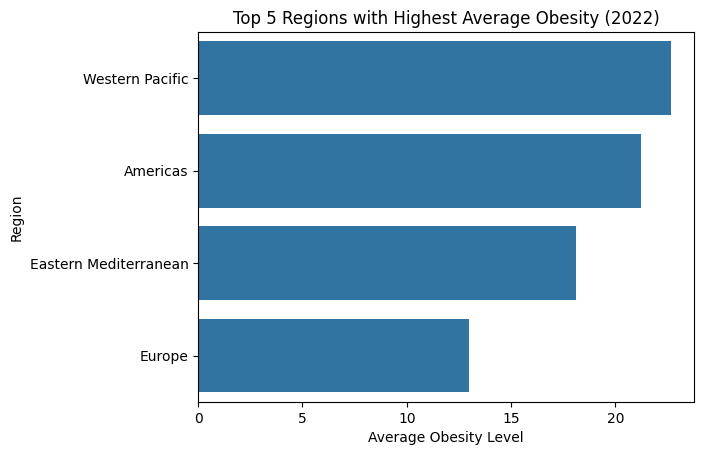

In [29]:
# Seaborn visualization for Query 1

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure()
sns.barplot(
    data=df_q1,
    x="avg_obesity",
    y="Region"
)

plt.xlabel("Average Obesity Level")
plt.ylabel("Region")
plt.title("Top 5 Regions with Highest Average Obesity (2022)")
plt.show()


In [30]:
# Query 2: Top 5 countries with highest obesity estimates

q2 = """
SELECT Country,
       AVG(Mean_Estimate) AS avg_obesity
FROM obesity_powerbi
GROUP BY Country
ORDER BY avg_obesity DESC
LIMIT 5;
"""

df_q2 = pd.read_sql(q2, conn)
df_q2


,Country,avg_obesity
0,Niue,40.664873
1,Cook Islands,39.917173
2,Nauru,38.512100
3,Tokelau,37.960966
4,American Samoa,36.892015


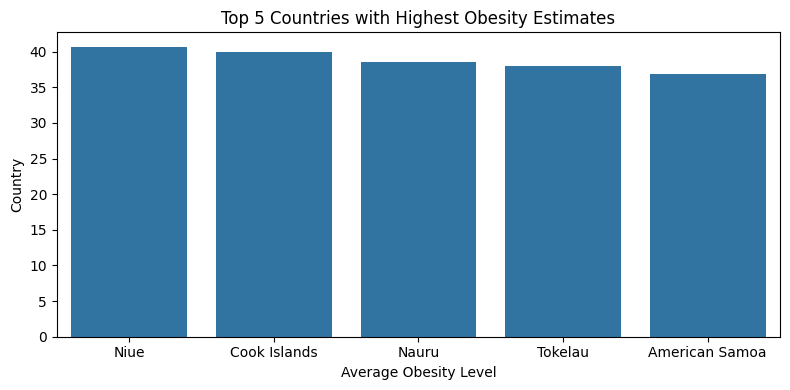

In [32]:
# Seaborn visualization for Query 2

plt.figure(figsize=(8, 4))
sns.barplot(
    data=df_q2,
    y="avg_obesity",
    x="Country"
)

plt.xlabel("Average Obesity Level")
plt.ylabel("Country")
plt.title("Top 5 Countries with Highest Obesity Estimates")
plt.tight_layout()
plt.show()


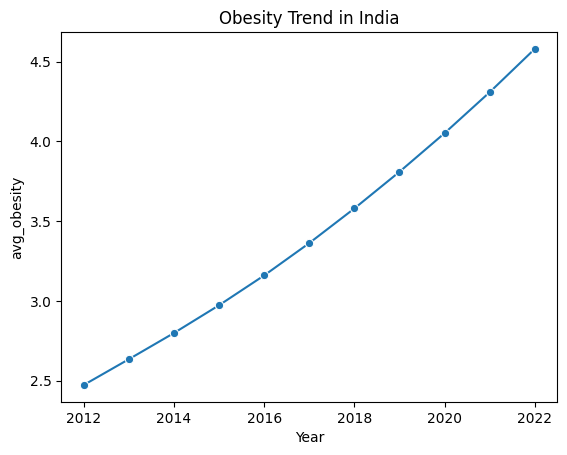

In [33]:
# Query 3: Obesity trend in India over the years

q3 = """
SELECT Year,
       AVG(Mean_Estimate) AS avg_obesity
FROM obesity_powerbi
WHERE Country = 'India'
GROUP BY Year
ORDER BY Year;
"""

df_q3 = pd.read_sql(q3, conn)

sns.lineplot(data=df_q3, x="Year", y="avg_obesity", marker="o")
plt.title("Obesity Trend in India")
plt.show()


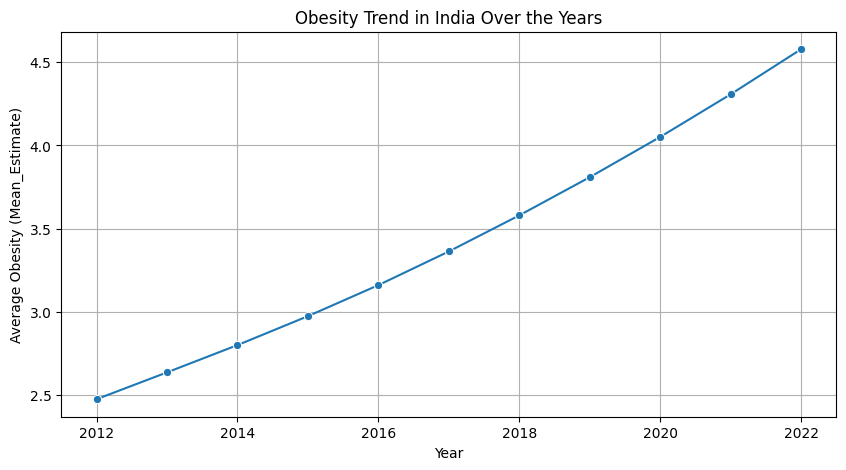

In [34]:
# Query 3: Obesity trend in India over the years (Mean_Estimate)

query_3 = """
SELECT
    Year,
    AVG(Mean_Estimate) AS avg_obesity
FROM obesity_powerbi
WHERE Country = 'India'
GROUP BY Year
ORDER BY Year;
"""

# Read query result into DataFrame
df_q3 = pd.read_sql(query_3, conn)

# Plot using Seaborn
plt.figure(figsize=(10, 5))
sns.lineplot(data=df_q3, x="Year", y="avg_obesity", marker="o")

plt.title("Obesity Trend in India Over the Years")
plt.xlabel("Year")
plt.ylabel("Average Obesity (Mean_Estimate)")
plt.grid(True)

plt.show()


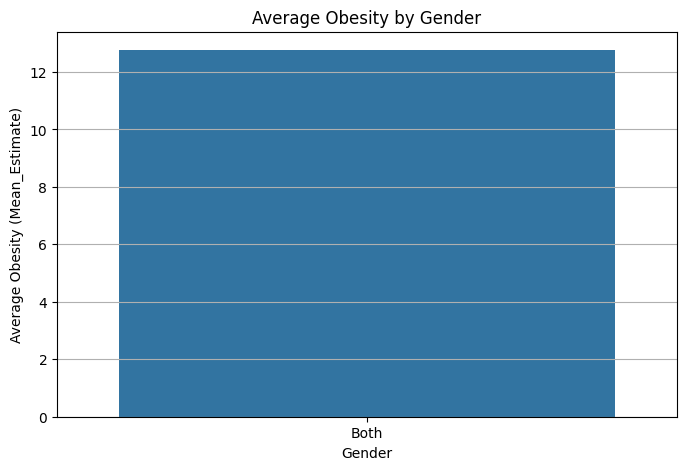

In [35]:
# Query 4: Average obesity by gender

query_4 = """
SELECT
    Gender,
    AVG(Mean_Estimate) AS avg_obesity
FROM obesity_powerbi
WHERE Gender IS NOT NULL
GROUP BY Gender
ORDER BY avg_obesity DESC;
"""
#“Gender-wise comparison is limited because the dataset mainly contains combined gender values.”
# Read query result into DataFrame
df_q4 = pd.read_sql(query_4, conn)

# Plot using Seaborn
plt.figure(figsize=(8, 5))
sns.barplot(data=df_q4, x="Gender", y="avg_obesity")

plt.title("Average Obesity by Gender")
plt.xlabel("Gender")
plt.ylabel("Average Obesity (Mean_Estimate)")
plt.grid(axis="y")

plt.show()


In [39]:
print(df_q5.columns)


Index(['Obesity_Level', 'age_group', 'country_count'], dtype='object')


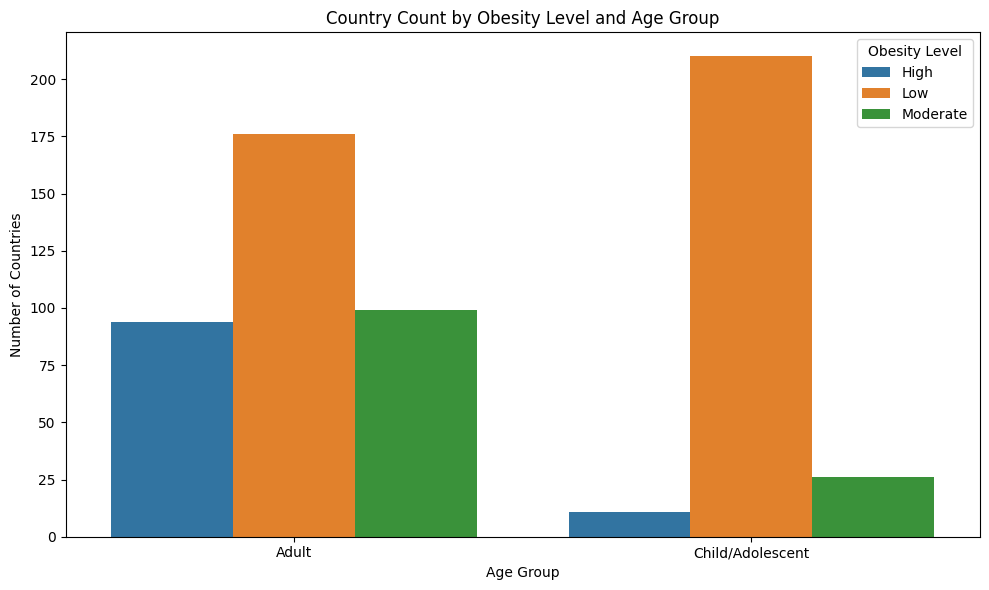

In [40]:
# Query 5: Country count by obesity level category and age group

query_5 = """
SELECT
    Obesity_Level,
    age_group,
    COUNT(DISTINCT Country) AS country_count
FROM obesity_powerbi
GROUP BY Obesity_Level, age_group;
"""

df_q5 = pd.read_sql(query_5, conn)

# Plot using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(
    data=df_q5,
    x="age_group",
    y="country_count",
    hue="Obesity_Level"
)

plt.title("Country Count by Obesity Level and Age Group")
plt.xlabel("Age Group")
plt.ylabel("Number of Countries")
plt.legend(title="Obesity Level")
plt.tight_layout()
plt.show()


/tmp/ipython-input-3170477603.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


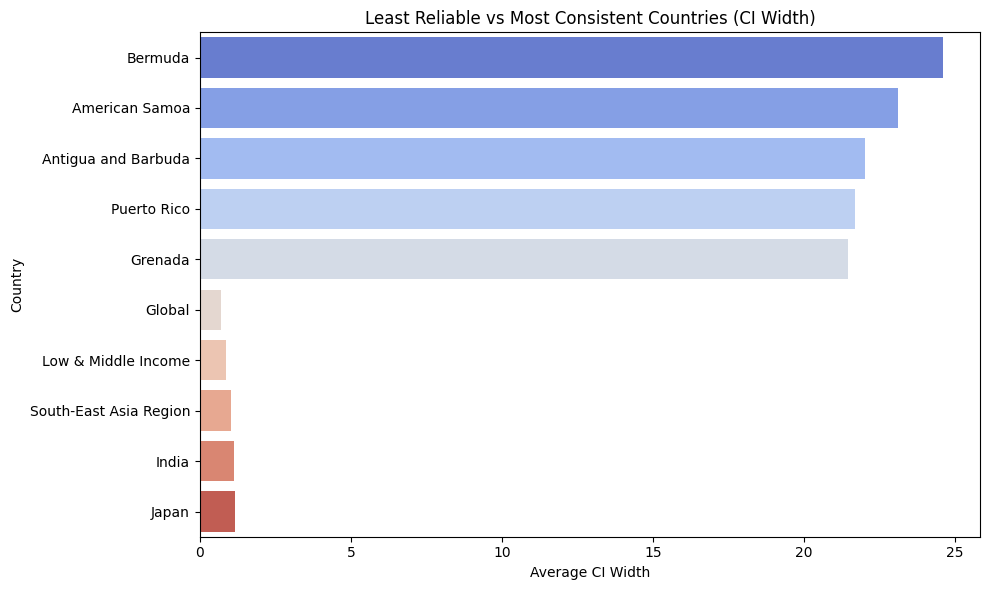

In [41]:
# Query 6:
# Top 5 least reliable countries (highest avg CI_Width)
# Top 5 most consistent countries (lowest avg CI_Width)

import matplotlib.pyplot as plt
import seaborn as sns

query_6 = """
SELECT
    Country,
    AVG(CI_Width) AS avg_ci_width
FROM obesity_powerbi
GROUP BY Country
"""

df_q6 = pd.read_sql(query_6, conn)

# Top 5 highest CI_Width (least reliable)
top_5_high_ci = df_q6.sort_values("avg_ci_width", ascending=False).head(5)

# Top 5 lowest CI_Width (most consistent)
top_5_low_ci = df_q6.sort_values("avg_ci_width", ascending=True).head(5)

# Combine both
df_q6_plot = pd.concat([top_5_high_ci, top_5_low_ci])

plt.figure(figsize=(10, 6))
sns.barplot(
    data=df_q6_plot,
    x="avg_ci_width",
    y="Country",
    palette="coolwarm"
)

plt.title("Least Reliable vs Most Consistent Countries (CI Width)")
plt.xlabel("Average CI Width")
plt.ylabel("Country")
plt.tight_layout()
plt.show()


#CI Width represents the uncertainty range of the obesity estimate. Smaller CI Width means more reliable data, while larger CI Width indicates higher variability and lower confidence.

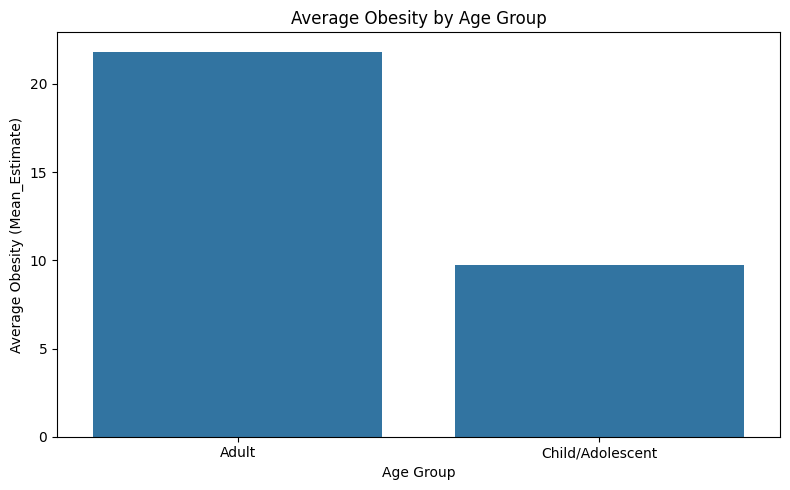

In [43]:
# Query 7: Average obesity by age group

query_7 = """
SELECT
    age_group,
    AVG(Mean_Estimate) AS avg_obesity
FROM obesity_powerbi
GROUP BY age_group
ORDER BY avg_obesity DESC;
"""

df_q7 = pd.read_sql(query_7, conn)

# Seaborn bar plot
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.barplot(
    data=df_q7,
    x="age_group",
    y="avg_obesity"
)

plt.title("Average Obesity by Age Group")
plt.xlabel("Age Group")
plt.ylabel("Average Obesity (Mean_Estimate)")
plt.tight_layout()
plt.show()


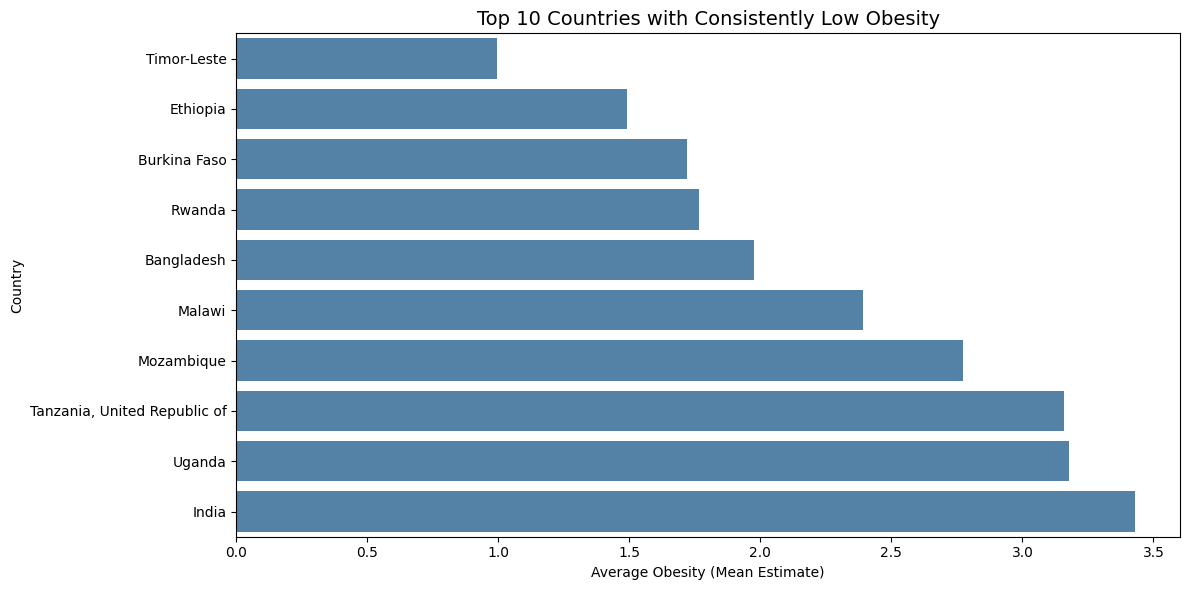

In [46]:
# Clean & clear visualization for Query 8

import matplotlib.pyplot as plt
import seaborn as sns

# Sort for better readability
df_q8_sorted = df_q8.sort_values("avg_obesity", ascending=True)

plt.figure(figsize=(12, 6))

sns.barplot(
    data=df_q8_sorted,
    y="Country",                 # Country on Y-axis (clear labels)
    x="avg_obesity",             # Obesity on X-axis
    color="steelblue"
)

plt.title("Top 10 Countries with Consistently Low Obesity", fontsize=14)
plt.xlabel("Average Obesity (Mean Estimate)")
plt.ylabel("Country")

plt.tight_layout()   # 🔑 prevents overlap
plt.show()


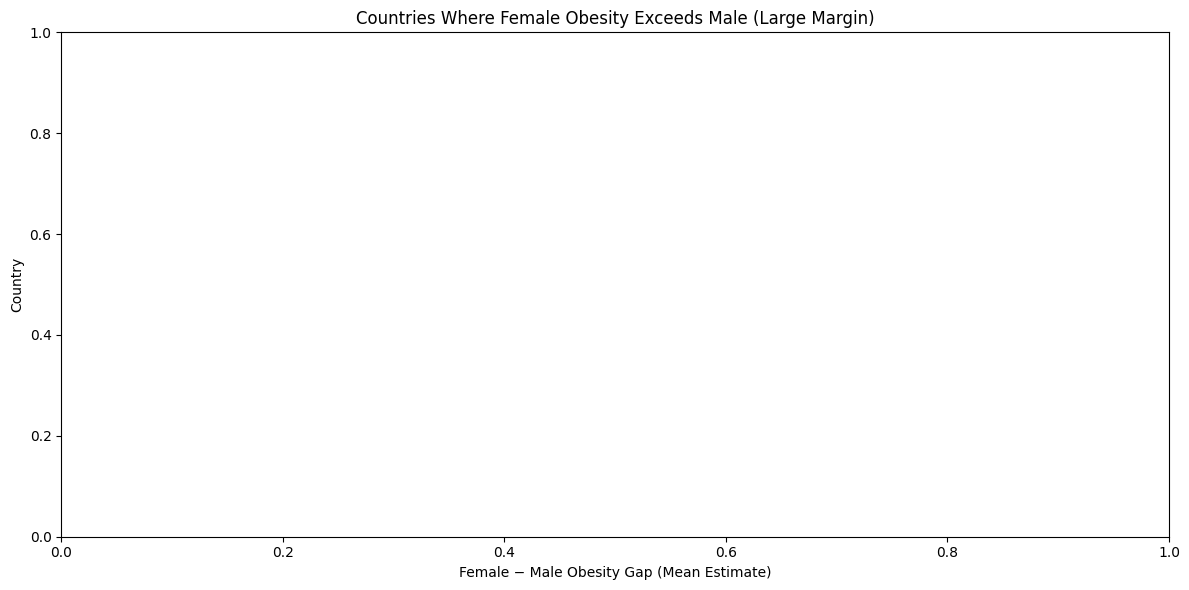

In [47]:
# Query 9: Countries where female obesity exceeds male obesity by a large margin (same year)

query_9 = """
SELECT
    Country,
    Year,
    AVG(CASE WHEN Gender = 'Female' THEN Mean_Estimate END) AS female_obesity,
    AVG(CASE WHEN Gender = 'Male' THEN Mean_Estimate END) AS male_obesity,
    (AVG(CASE WHEN Gender = 'Female' THEN Mean_Estimate END) -
     AVG(CASE WHEN Gender = 'Male' THEN Mean_Estimate END)) AS obesity_gap
FROM obesity_powerbi
GROUP BY Country, Year
HAVING obesity_gap IS NOT NULL
   AND obesity_gap > 5
ORDER BY obesity_gap DESC
LIMIT 10;
"""

df_q9 = pd.read_sql(query_9, conn)

# Plot using Seaborn
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))

sns.barplot(
    data=df_q9,
    y="Country",
    x="obesity_gap",
    color="salmon"
)

plt.title("Countries Where Female Obesity Exceeds Male (Large Margin)")
plt.xlabel("Female − Male Obesity Gap (Mean Estimate)")
plt.ylabel("Country")

plt.tight_layout()
plt.show()


In [48]:
pd.read_sql(
    "SELECT DISTINCT Gender FROM obesity_powerbi",
    conn
)


,Gender
0,Both


In [49]:
# Query 9 (Modified):
# Countries with large obesity variation over years (max - min)

query_9 = """
SELECT
    Country,
    MAX(Mean_Estimate) - MIN(Mean_Estimate) AS obesity_variation
FROM obesity_powerbi
GROUP BY Country
HAVING obesity_variation > 5
ORDER BY obesity_variation DESC
LIMIT 10;
"""

df_q9 = pd.read_sql(query_9, conn)
df_q9


,Country,obesity_variation
0,American Samoa,69.872773
1,Tonga,61.650150
2,Samoa,61.579215
3,Nauru,57.511939
4,Tuvalu,57.412850
5,Tokelau,57.103929
6,Cook Islands,56.728450
7,Niue,51.542111
8,Kiribati,48.586033
9,Marshall Islands,48.244784


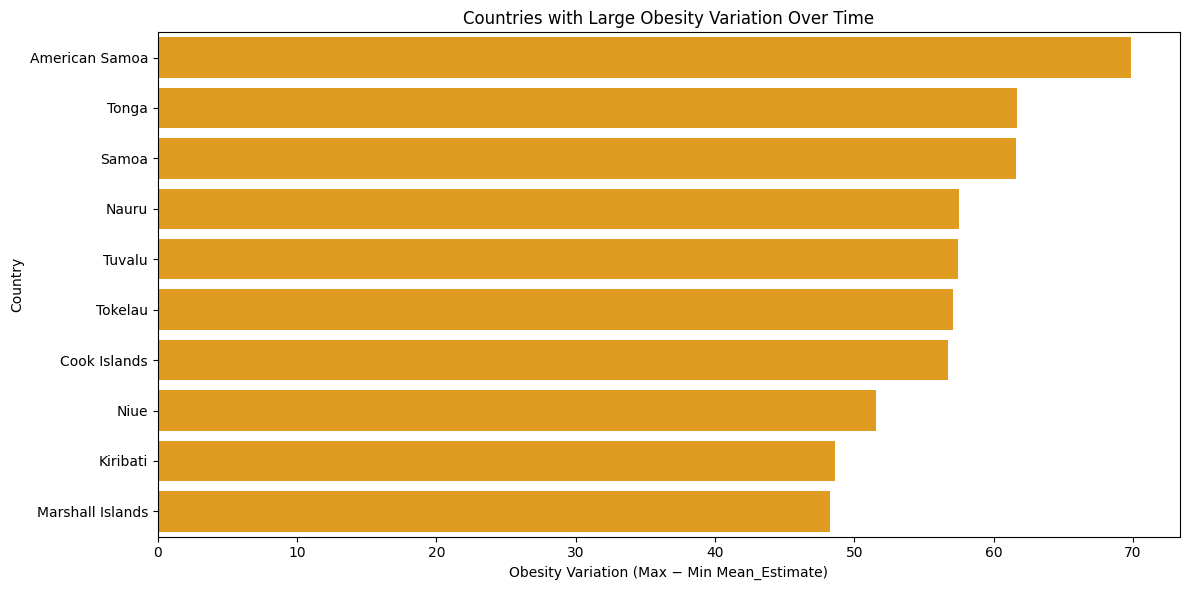

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,6))

sns.barplot(
    data=df_q9,
    y="Country",
    x="obesity_variation",
    color="orange"
)

plt.title("Countries with Large Obesity Variation Over Time")
plt.xlabel("Obesity Variation (Max − Min Mean_Estimate)")
plt.ylabel("Country")

plt.tight_layout()
plt.show()


In [52]:
# Query 10:
# Global average obesity percentage per year

query_10 = """
SELECT
    Year,
    AVG(Mean_Estimate) AS avg_obesity
FROM obesity_powerbi
GROUP BY Year
ORDER BY Year;
"""

df_q10 = pd.read_sql(query_10, conn)
df_q10


,Year,avg_obesity
0,2012,11.061969
1,2013,11.359637
2,2014,11.670343
3,2015,11.994231
4,2016,12.333907
5,2017,12.689997
6,2018,13.060296
7,2019,13.444604
8,2020,13.843002
9,2021,14.250923


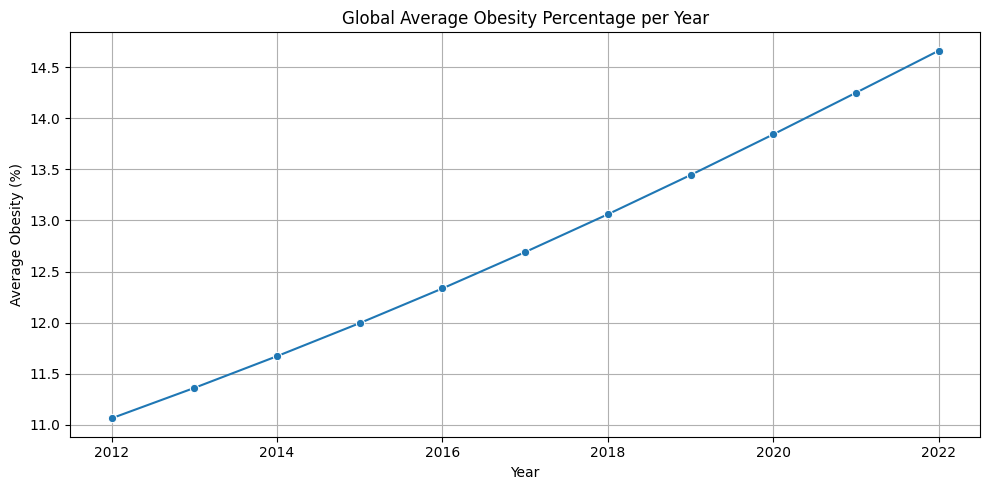

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,5))

sns.lineplot(
    data=df_q10,
    x="Year",
    y="avg_obesity",
    marker="o"
)

plt.title("Global Average Obesity Percentage per Year")
plt.xlabel("Year")
plt.ylabel("Average Obesity (%)")

plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
#Malnutrition

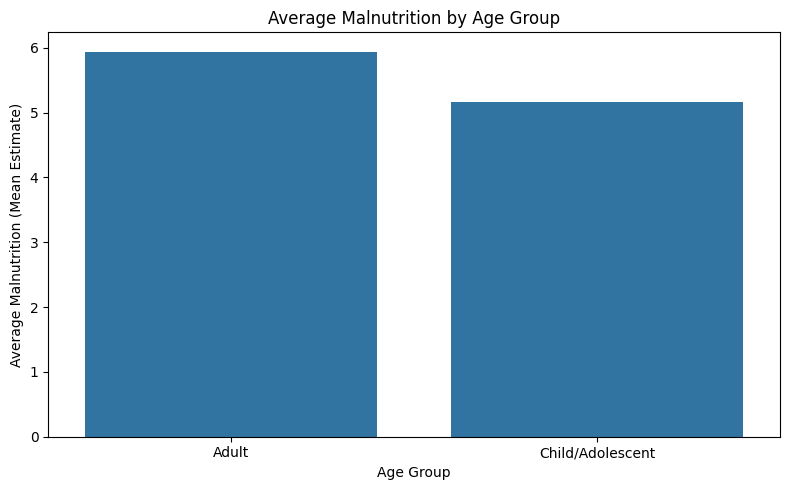

In [55]:
# Query 1: Average malnutrition by age_group

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

q1 = """
SELECT age_group, AVG(mean_estimate) AS avg_malnutrition
FROM malnutrition_powerbi
GROUP BY age_group
ORDER BY avg_malnutrition DESC;
"""

df_q1 = pd.read_sql(q1, conn)

plt.figure(figsize=(8,5))
sns.barplot(
    data=df_q1,
    x="age_group",
    y="avg_malnutrition"
)

plt.title("Average Malnutrition by Age Group")
plt.xlabel("Age Group")
plt.ylabel("Average Malnutrition (Mean Estimate)")
plt.tight_layout()
plt.show()


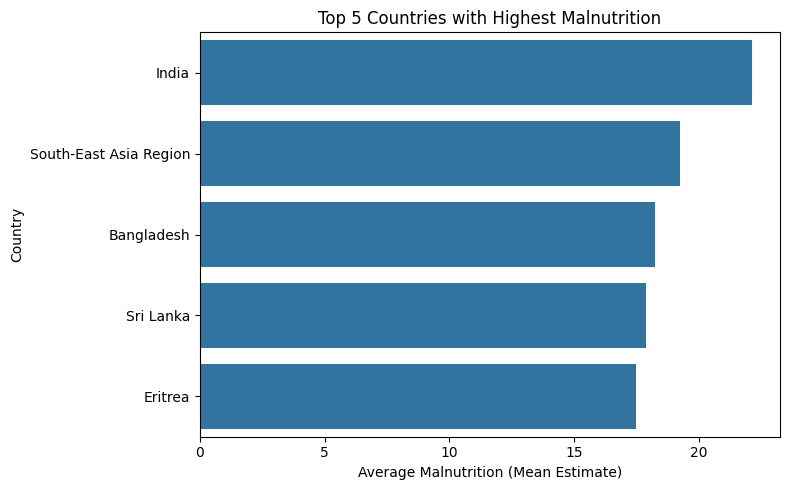

In [56]:
# Query 2: Top 5 countries with highest malnutrition (mean_estimate)

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

q2 = """
SELECT
    Country,
    AVG(mean_estimate) AS avg_malnutrition
FROM malnutrition_powerbi
GROUP BY Country
ORDER BY avg_malnutrition DESC
LIMIT 5;
"""

df_q2 = pd.read_sql(q2, conn)

plt.figure(figsize=(8,5))
sns.barplot(
    data=df_q2,
    x="avg_malnutrition",
    y="Country"
)

plt.title("Top 5 Countries with Highest Malnutrition")
plt.xlabel("Average Malnutrition (Mean Estimate)")
plt.ylabel("Country")
plt.tight_layout()
plt.show()


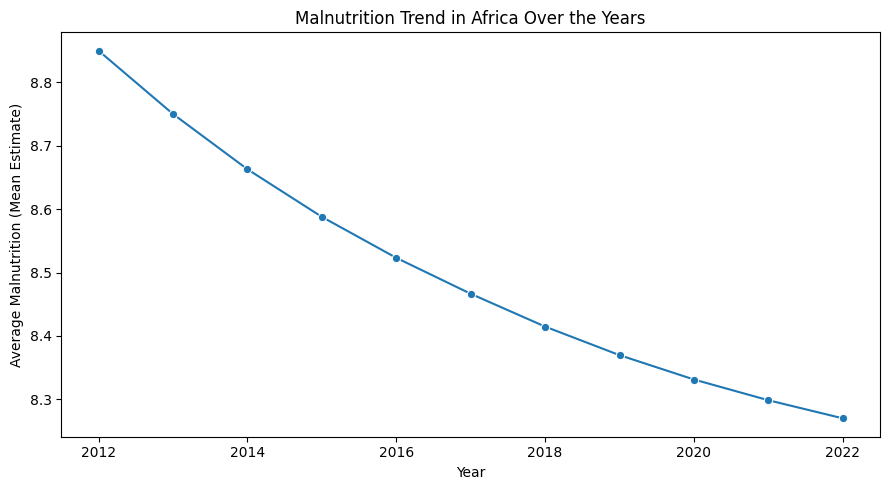

In [57]:
# Query 3: Malnutrition trend in African region over the years

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

q3 = """
SELECT
    Year,
    AVG(mean_estimate) AS avg_malnutrition
FROM malnutrition_powerbi
WHERE Region = 'Africa'
GROUP BY Year
ORDER BY Year;
"""

df_q3 = pd.read_sql(q3, conn)

plt.figure(figsize=(9,5))
sns.lineplot(
    data=df_q3,
    x="Year",
    y="avg_malnutrition",
    marker="o"
)

plt.title("Malnutrition Trend in Africa Over the Years")
plt.xlabel("Year")
plt.ylabel("Average Malnutrition (Mean Estimate)")
plt.tight_layout()
plt.show()


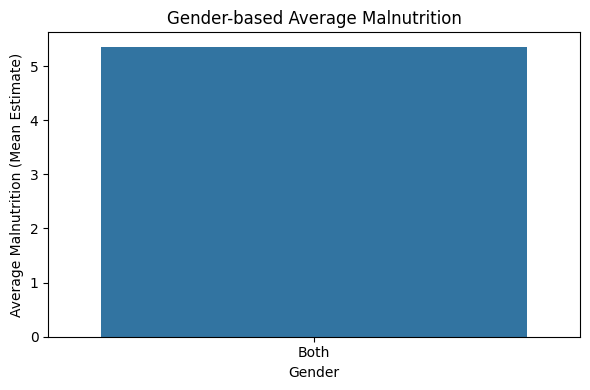

In [58]:
# Query 4: Gender-based average malnutrition

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

q4 = """
SELECT
    Gender,
    AVG(mean_estimate) AS avg_malnutrition
FROM malnutrition_powerbi
GROUP BY Gender;
"""

df_q4 = pd.read_sql(q4, conn)

plt.figure(figsize=(6,4))
sns.barplot(
    data=df_q4,
    x="Gender",
    y="avg_malnutrition"
)

plt.title("Gender-based Average Malnutrition")
plt.xlabel("Gender")
plt.ylabel("Average Malnutrition (Mean Estimate)")
plt.tight_layout()
plt.show()


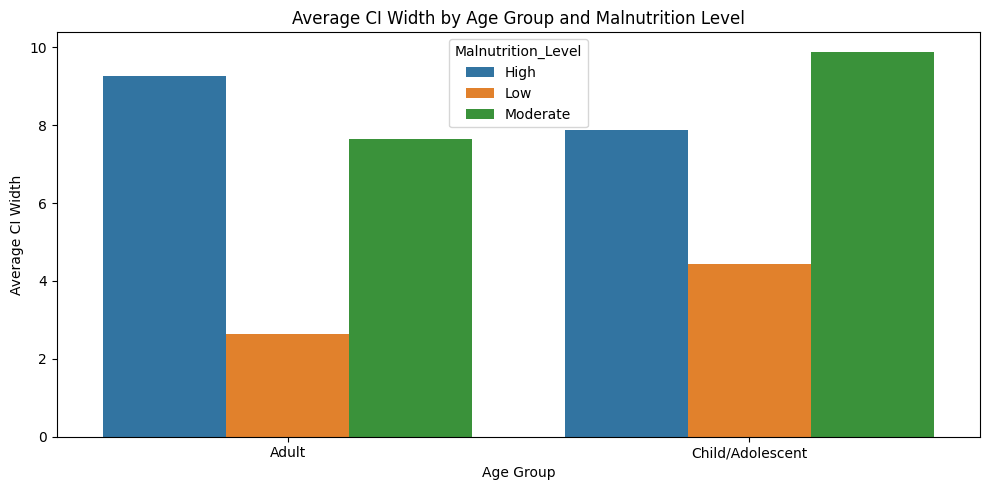

In [60]:
# Query 5: Malnutrition level-wise average CI_Width by age_group (FIXED)

import seaborn as sns
import matplotlib.pyplot as plt

q5 = """
SELECT
    age_group,
    Malnutrition_Level,
    AVG(CI_Width) AS avg_ci_width
FROM malnutrition_powerbi
GROUP BY age_group, Malnutrition_Level
ORDER BY age_group;
"""

df_q5 = pd.read_sql(q5, conn)

plt.figure(figsize=(10,5))
sns.barplot(
    data=df_q5,
    x="age_group",
    y="avg_ci_width",
    hue="Malnutrition_Level"
)

plt.title("Average CI Width by Age Group and Malnutrition Level")
plt.xlabel("Age Group")
plt.ylabel("Average CI Width")
plt.tight_layout()
plt.show()


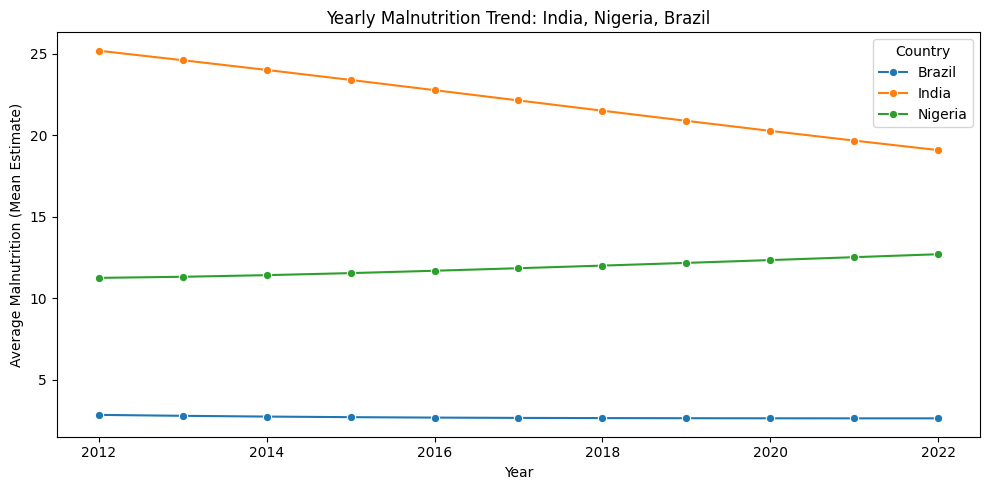

In [61]:
# Query 6: Yearly malnutrition change in India, Nigeria, Brazil

q6 = """
SELECT
    Country,
    Year,
    AVG(mean_estimate) AS avg_malnutrition
FROM malnutrition_powerbi
WHERE Country IN ('India', 'Nigeria', 'Brazil')
GROUP BY Country, Year
ORDER BY Country, Year;
"""

df_q6 = pd.read_sql(q6, conn)

plt.figure(figsize=(10,5))
sns.lineplot(
    data=df_q6,
    x="Year",
    y="avg_malnutrition",
    hue="Country",
    marker="o"
)

plt.title("Yearly Malnutrition Trend: India, Nigeria, Brazil")
plt.xlabel("Year")
plt.ylabel("Average Malnutrition (Mean Estimate)")
plt.tight_layout()
plt.show()


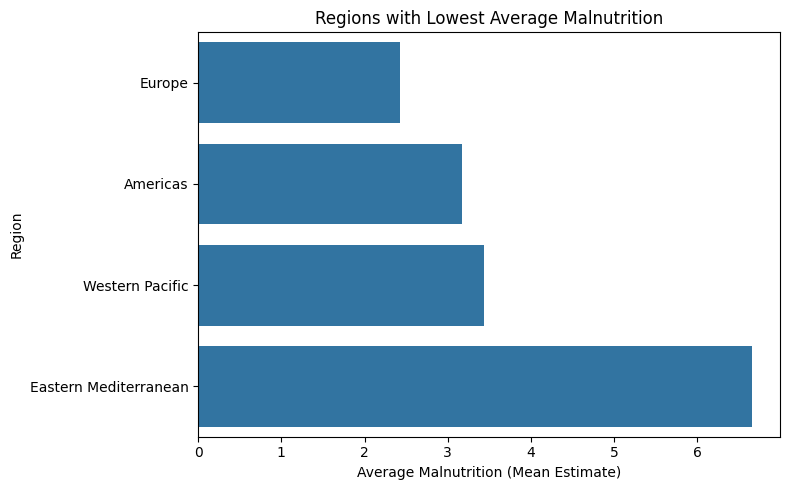

In [63]:
# Query 7: Regions with lowest malnutrition averages

q7 = """
SELECT
    Region,
    AVG(mean_estimate) AS avg_malnutrition
FROM malnutrition_powerbi
GROUP BY Region
ORDER BY avg_malnutrition ASC
LIMIT 5;
"""

df_q7 = pd.read_sql(q7, conn)

plt.figure(figsize=(8,5))
sns.barplot(
    data=df_q7,
    x="avg_malnutrition",
    y="Region"
)

plt.title("Regions with Lowest Average Malnutrition")
plt.xlabel("Average Malnutrition (Mean Estimate)")
plt.ylabel("Region")
plt.tight_layout()
plt.show()


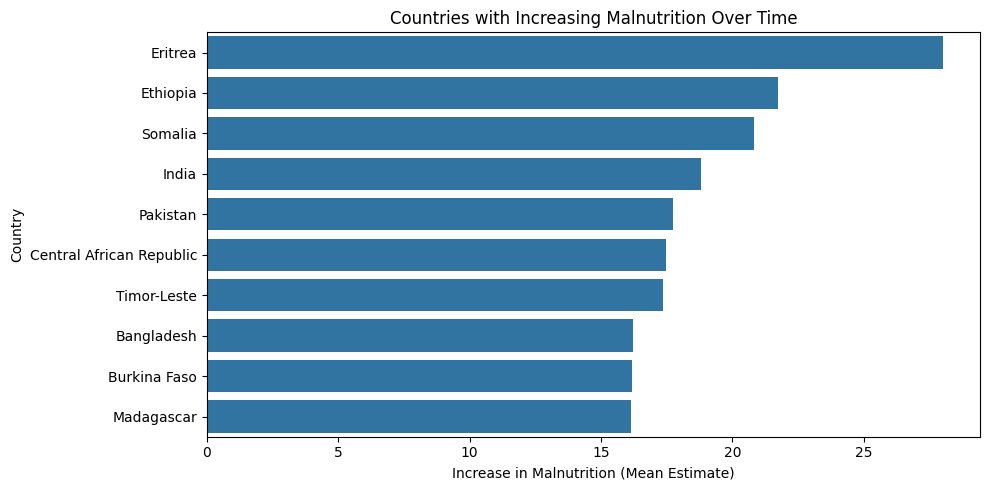

In [64]:
# Query 8: Countries with increasing malnutrition over time

q8 = """
SELECT
    Country,
    MIN(mean_estimate) AS early_malnutrition,
    MAX(mean_estimate) AS recent_malnutrition,
    (MAX(mean_estimate) - MIN(mean_estimate)) AS change_value
FROM malnutrition_powerbi
GROUP BY Country
HAVING change_value > 0
ORDER BY change_value DESC
LIMIT 10;
"""

df_q8 = pd.read_sql(q8, conn)

plt.figure(figsize=(10,5))
sns.barplot(
    data=df_q8,
    x="change_value",
    y="Country"
)

plt.title("Countries with Increasing Malnutrition Over Time")
plt.xlabel("Increase in Malnutrition (Mean Estimate)")
plt.ylabel("Country")
plt.tight_layout()
plt.show()


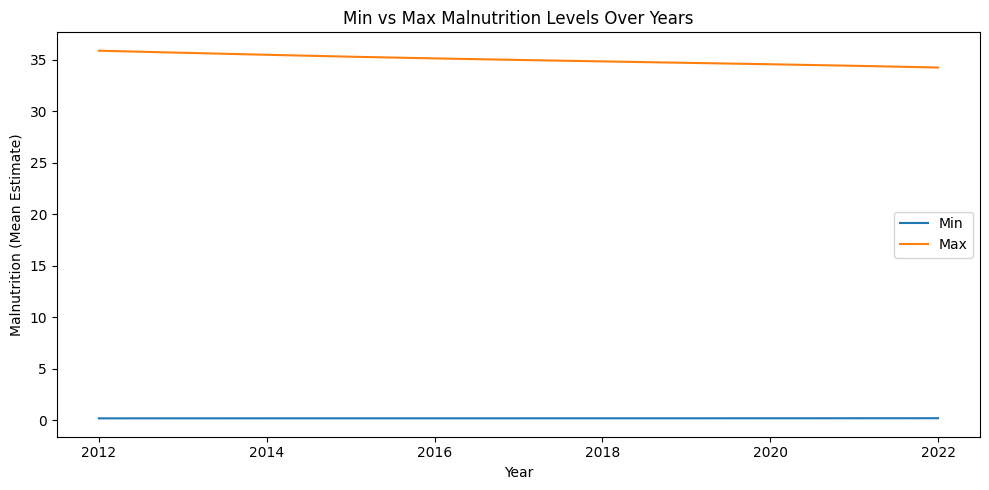

In [65]:
# Query 9: Min and Max malnutrition levels per year

q9 = """
SELECT
    Year,
    MIN(mean_estimate) AS min_malnutrition,
    MAX(mean_estimate) AS max_malnutrition
FROM malnutrition_powerbi
GROUP BY Year
ORDER BY Year;
"""

df_q9 = pd.read_sql(q9, conn)

plt.figure(figsize=(10,5))
plt.plot(df_q9["Year"], df_q9["min_malnutrition"], label="Min")
plt.plot(df_q9["Year"], df_q9["max_malnutrition"], label="Max")

plt.title("Min vs Max Malnutrition Levels Over Years")
plt.xlabel("Year")
plt.ylabel("Malnutrition (Mean Estimate)")
plt.legend()
plt.tight_layout()
plt.show()


In [66]:
# Query 10: High CI_Width flags (CI_Width > 5)

q10 = """
SELECT
    Country,
    Year,
    CI_Width
FROM malnutrition_powerbi
WHERE CI_Width > 5
ORDER BY CI_Width DESC
LIMIT 10;
"""

df_q10 = pd.read_sql(q10, conn)

df_q10


,Country,Year,CI_Width
0,Senegal,2022,26.701744
1,Senegal,2021,25.679344
2,Senegal,2020,24.586366
3,Mauritania,2022,23.810544
4,Senegal,2019,23.466898
5,Equatorial Guinea,2022,23.417751
6,Senegal,2022,23.389659
7,Senegal,2022,23.368836
8,Somalia,2022,23.081330
9,Gambia,2022,23.012805


In [ ]:
#Combined query

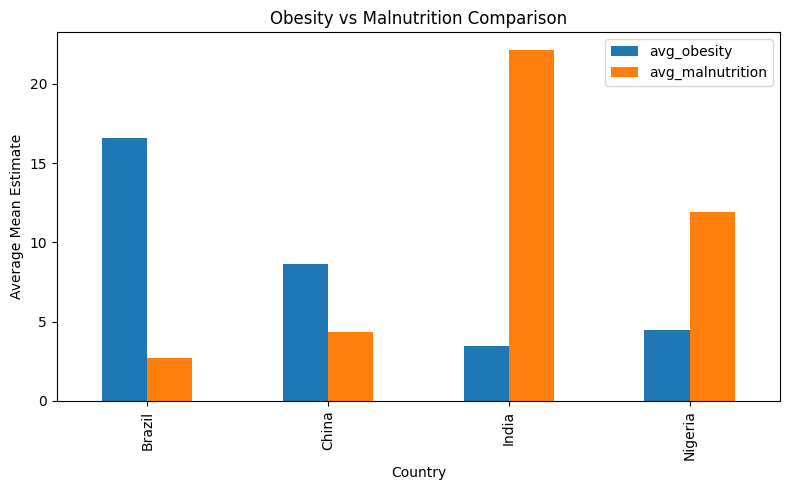

In [68]:
# Combined Query 1: Obesity vs Malnutrition comparison by country

q_c1 = """
SELECT
    o.Country,
    AVG(o.Mean_Estimate) AS avg_obesity,
    AVG(m.mean_estimate) AS avg_malnutrition
FROM obesity_powerbi o
JOIN malnutrition_powerbi m
ON o.Country = m.Country
WHERE o.Country IN ('India','USA','Brazil','Nigeria','China')
GROUP BY o.Country;
"""

df_c1 = pd.read_sql(q_c1, conn)

df_c1.plot(
    x="Country",
    kind="bar",
    figsize=(8,5),
    title="Obesity vs Malnutrition Comparison"
)

plt.ylabel("Average Mean Estimate")
plt.tight_layout()
plt.show()


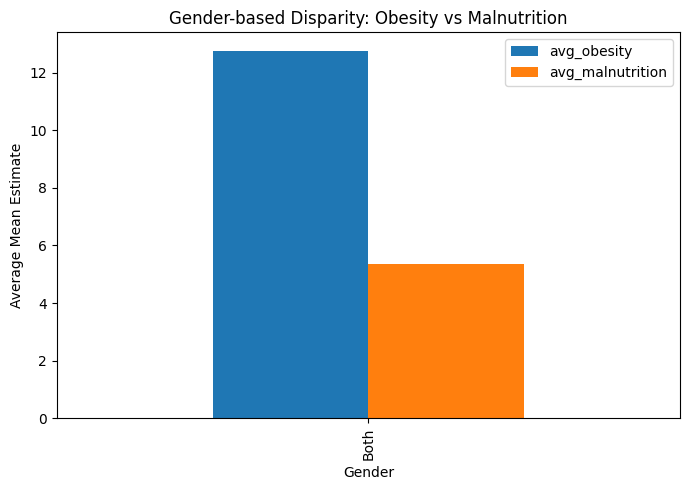

In [70]:
# Combined Query 2 (FIXED): Gender-based disparity in both obesity and malnutrition

q_c2 = """
SELECT
    o.Gender AS Gender,
    AVG(o.Mean_Estimate) AS avg_obesity,
    AVG(m.mean_estimate) AS avg_malnutrition
FROM obesity_powerbi o
JOIN malnutrition_powerbi m
ON o.Country = m.Country
AND o.Year = m.Year
AND o.Gender = m.Gender
GROUP BY o.Gender;
"""

df_c2 = pd.read_sql(q_c2, conn)

df_c2.plot(
    x="Gender",
    kind="bar",
    figsize=(7,5),
    title="Gender-based Disparity: Obesity vs Malnutrition"
)

plt.ylabel("Average Mean Estimate")
plt.tight_layout()
plt.show()


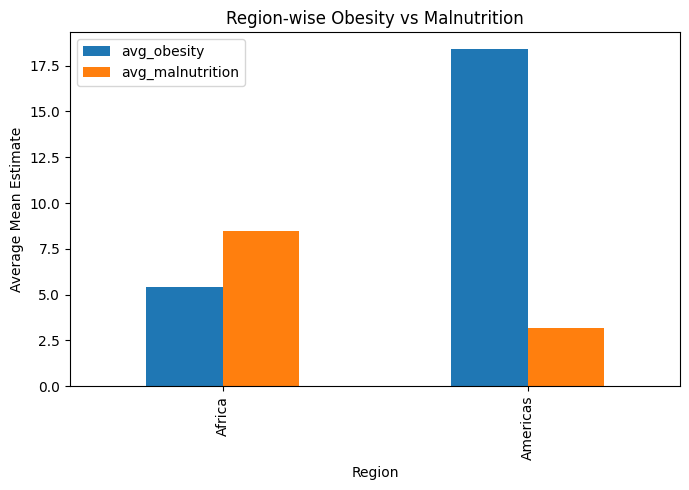

In [71]:
# Combined Query 3: Region-wise averages (Africa vs Americas)

q_c3 = """
SELECT
    o.Region,
    AVG(o.Mean_Estimate) AS avg_obesity,
    AVG(m.mean_estimate) AS avg_malnutrition
FROM obesity_powerbi o
JOIN malnutrition_powerbi m
ON o.Region = m.Region
WHERE o.Region IN ('Africa','Americas')
GROUP BY o.Region;
"""

df_c3 = pd.read_sql(q_c3, conn)

df_c3.plot(
    x="Region",
    kind="bar",
    figsize=(7,5),
    title="Region-wise Obesity vs Malnutrition"
)

plt.ylabel("Average Mean Estimate")
plt.tight_layout()
plt.show()


In [72]:
# Combined Query 4: Obesity up & malnutrition down

q_c4 = """
SELECT
    o.Country,
    (MAX(o.Mean_Estimate) - MIN(o.Mean_Estimate)) AS obesity_change,
    (MAX(m.mean_estimate) - MIN(m.mean_estimate)) AS malnutrition_change
FROM obesity_powerbi o
JOIN malnutrition_powerbi m
ON o.Country = m.Country
GROUP BY o.Country
HAVING obesity_change > 0 AND malnutrition_change < 0
LIMIT 10;
"""

df_c4 = pd.read_sql(q_c4, conn)

df_c4


,Country,obesity_change,malnutrition_change


In [73]:
# Combined Query 4 (debug view): Obesity & Malnutrition change by country

q_c4_debug = """
SELECT
    o.Country,
    (MAX(o.Mean_Estimate) - MIN(o.Mean_Estimate)) AS obesity_change,
    (MAX(m.Mean_Estimate) - MIN(m.Mean_Estimate)) AS malnutrition_change
FROM obesity_powerbi o
JOIN malnutrition_powerbi m
    ON o.Country = m.Country
GROUP BY o.Country
ORDER BY obesity_change DESC
LIMIT 10;
"""

df_c4_debug = pd.read_sql(q_c4_debug, conn)
df_c4_debug


,Country,obesity_change,malnutrition_change
0,American Samoa,69.872773,0.900433
1,Tonga,61.650150,0.893908
2,Samoa,61.579215,1.472992
3,Nauru,57.511939,1.448612
4,Tuvalu,57.412850,3.026137
5,Tokelau,57.103929,1.272598
6,Cook Islands,56.728450,1.187258
7,Niue,51.542111,0.896485
8,Kiribati,48.586033,1.458298
9,Marshall Islands,48.244784,3.399414


In [ ]:
# Combined Query 4: Countries where obesity increased and malnutrition is stable or reduced

q_c4 = """
SELECT
    o.Country,
    (MAX(o.Mean_Estimate) - MIN(o.Mean_Estimate)) AS obesity_change,
    (MAX(m.Mean_Estimate) - MIN(m.Mean_Estimate)) AS malnutrition_change
FROM obesity_powerbi o
JOIN malnutrition_powerbi m
    ON o.Country = m.Country
GROUP BY o.Country
HAVING obesity_change > 0 AND malnutrition_change <= 0
ORDER BY obesity_change DESC
LIMIT 10;
"""

df_c4 = pd.read_sql(q_c4, conn)
df_c4


In [77]:
# Combined Query 5:
# Age-wise trend analysis for Obesity and Malnutrition

q_c5 = """
SELECT
    o.Year,
    o.Age_Group AS age_group,
    AVG(o.Mean_Estimate) AS avg_obesity,
    AVG(m.Mean_Estimate) AS avg_malnutrition
FROM obesity_powerbi o
JOIN malnutrition_powerbi m
    ON o.Country = m.Country
   AND o.Year = m.Year
   AND o.Age_Group = m.Age_Group
GROUP BY o.Year, o.Age_Group
ORDER BY o.Year, o.Age_Group;
"""

df_c5 = pd.read_sql(q_c5, conn)
df_c5.head()


,Year,age_group,avg_obesity,avg_malnutrition
0,2012,Adult,19.517937,6.443665
1,2012,Child/Adolescent,8.243313,5.274296
2,2013,Adult,19.949264,6.320996
3,2013,Child/Adolescent,8.496428,5.238137
4,2014,Adult,20.391706,6.206418


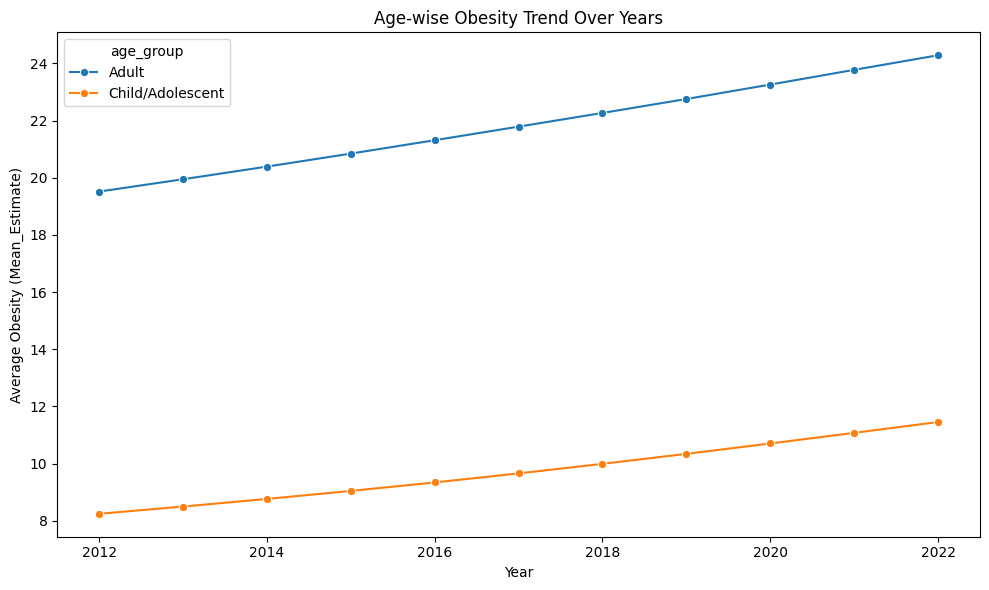

In [78]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))

sns.lineplot(
    data=df_c5,
    x="Year",
    y="avg_obesity",
    hue="age_group",
    marker="o"
)

plt.title("Age-wise Obesity Trend Over Years")
plt.ylabel("Average Obesity (Mean_Estimate)")
plt.tight_layout()
plt.show()


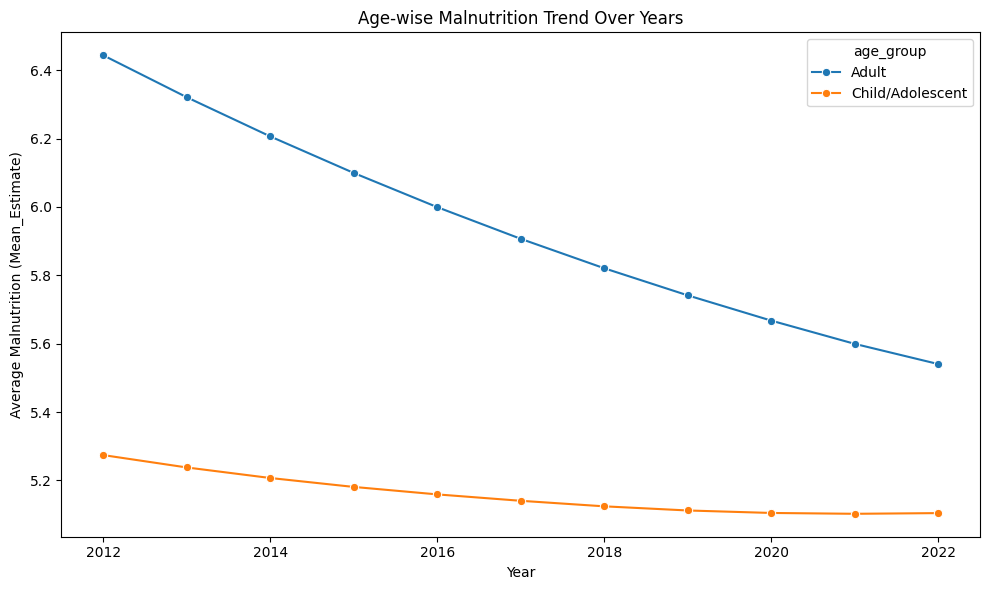

In [79]:
plt.figure(figsize=(10,6))

sns.lineplot(
    data=df_c5,
    x="Year",
    y="avg_malnutrition",
    hue="age_group",
    marker="o"
)

plt.title("Age-wise Malnutrition Trend Over Years")
plt.ylabel("Average Malnutrition (Mean_Estimate)")
plt.tight_layout()
plt.show()
